# Customer Churn Prediction 

This notebook performs a churn prediction pipeline:
- Data cleaning (drop irrelevant cols)
- Encoding categorical features with one-hot
- Scaling numeric features
- Train/Test split
- Modeling: Logistic Regression, Random Forest, XGBoost
- Handling class imbalance with SMOTE
- Hyperparameter tuning (GridSearch for RandomForest)
- Evaluation metrics and ROC/AUC
- Feature importance and plots

Instructions: Run cells sequentially. Comments explain each step so you can present them in your meeting.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle

from sklearn.model_selection import train_test_split, GridSearchCVpip show scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Optional: XGBoost (if installed)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception as e:
    
    xgb_available = False
    print('XGBoost not available in this environment. You can install xgboost if you want to run it locally.')

In [ ]:
# Load cleaned data
df = pd.read_csv('cleaned_customer_churn.csv')
df.shape, df.columns
df.head()

,CustomerID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239,Competitor made better offer
1,9237-HQITU,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701,Moved
2,9305-CDSKC,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,...,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1,86,5372,Moved
3,7892-POOKP,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,...,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84,5003,Moved
4,0280-XJGEX,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,...,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1,89,5340,Competitor had better devices


In [18]:
#  1: Add an evaluation function 
def evaluate_model(model, X_test, y_test, name):
    """Calculates all required metrics (Accuracy, Precision, Recall, F1, ROC-AUC)."""
    y_pred = model.predict(X_test)
    # Get probabilities for ROC-AUC score
    y_proba = model.predict_proba(X_test)[:, 1] 
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    return pd.Series({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

In [19]:
# Drop irrelevant columns (as agreed)
drop_cols = ['CustomerID','Country','State','City','Zip Code','Lat Long','Latitude','Longitude','Churn Reason', 'Churn Score', 'CLTV']

for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

df.shape 


(7043, 20)

In [20]:
# Quick info and missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   object 
 6   Multiple Lines     7043 non-null   object 
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   object 
 9   Online Backup      7043 non-null   object 
 10  Device Protection  7043 non-null   object 
 11  Tech Support       7043 non-null   object 
 12  Streaming TV       7043 non-null   object 
 13  Streaming Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   object 
 16  Payment Method     7043 

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
dtype: int64

In [21]:
# Convert to float
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Drop rows with missing values
df.dropna(subset=['Total Charges'], inplace=True)

# Check
print("Missing values in Total Charges:", df['Total Charges'].isna().sum())

Missing values in Total Charges: 0


In [22]:
# Identify categorical and numeric columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print('Categorical columns:', cat_cols)
print('Numeric columns:', num_cols)

Categorical columns: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
Numeric columns: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value']


In [23]:
# One-hot encode categorical columns (drop_first to avoid multicollinearity)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.shape

(7032, 31)

In [24]:
# Target column
target = 'Churn Value'  # as agreed
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

print('X shape:', X.shape)
print('y distribution:\n', y.value_counts(normalize=True))

X shape: (7032, 30)
y distribution:
 Churn Value
0    0.734215
1    0.265785
Name: proportion, dtype: float64


In [25]:
# Handle class imbalance using SMOTE on training set (after split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Before resampling:', y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print('After SMOTE:', y_train_res.value_counts())

Before resampling: Churn Value
0    4130
1    1495
Name: count, dtype: int64
After SMOTE: Churn Value
0    4130
1    4130
Name: count, dtype: int64


In [26]:
# Remove target column from numeric columns if present
if target in num_cols:
    num_cols.remove(target)

# Scaling numeric features (fit on training only)
scaler = StandardScaler()
X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])





In [27]:

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print('Saved the fitted StandardScaler to scaler.pkl')


Saved the fitted StandardScaler to scaler.pkl


In [28]:
# Logistic Regression (baseline)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)



In [29]:

# Random Forest with comprehensive GridSearch
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [150, 300], 
    'max_depth': [10, 20, 30, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5] 
}

# Changed scoring to 'roc_auc' which is optimal for imbalanced classification
grid = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2) 
grid.fit(X_train_res, y_train_res)

best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [ ]:
# XGBoost 
if xgb_available:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_res, y_train_res)
    y_pred_xgb = xgb.predict(X_test)
   

c:\Users\Workstation\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:53:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


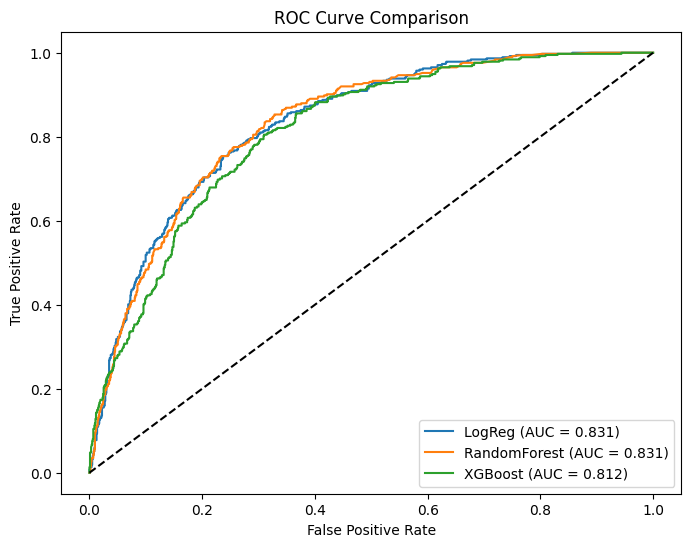

In [32]:
# ROC Curve for best models
plt.figure(figsize=(8,6))

# LR
y_proba_lr = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {auc_lr:.3f})')

# RF
y_proba_rf = best_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc_rf:.3f})')

# XGB if available
if xgb_available:
    y_proba_xgb = xgb.predict_proba(X_test)[:,1]
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
    auc_xgb = auc(fpr_xgb, tpr_xgb)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

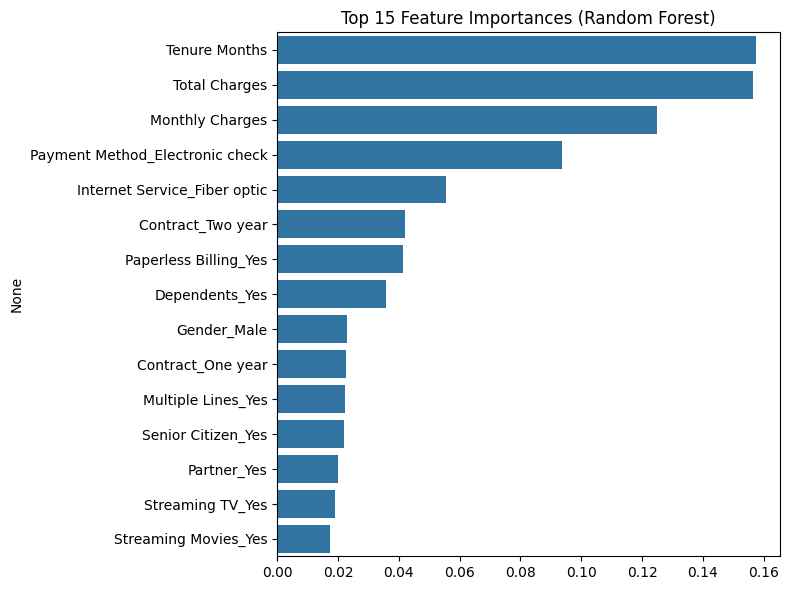

Saved best Random Forest to  best_random_forest.pkl


In [ ]:
# Feature importance from Random Forest (top 15)
importances = best_rf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [ ]:

# Collect results from all trained models using the evaluation function
# 1. Evaluate Logistic Regression
results_lr = evaluate_model(lr, X_test, y_test, 'Logistic Regression')

# 2. Evaluate Best Random Forest
results_rf = evaluate_model(best_rf, X_test, y_test, 'Random Forest (Tuned)')

# 3. Evaluate XGBoost (if available)
if xgb_available:
    results_xgb = evaluate_model(xgb, X_test, y_test, 'XGBoost (Default)')
    
    # Combine all results into a single DataFrame for comparison
    final_report = pd.concat([results_lr, results_rf, results_xgb], axis=1).T
else:
    final_report = pd.concat([results_lr, results_rf], axis=1).T

# Set Model name as index
final_report.set_index('Model', inplace=True) 

print('\n--- FINAL MODEL EVALUATION REPORT (COMPARING ALL MODELS) ---')
print(final_report.round(4))



# Save the trained best RF model for later use
with open('best_random_forest.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
print('Saved best Random Forest to best_random_forest.pkl')


--- FINAL MODEL EVALUATION REPORT (COMPARING ALL MODELS) ---
                       Accuracy Precision    Recall  F1-Score   ROC-AUC
Model                                                                  
Logistic Regression    0.775409   0.56621  0.663102  0.610837  0.831001
Random Forest (Tuned)  0.782516  0.585859  0.620321  0.602597  0.831276
XGBoost (Default)      0.773276  0.571429  0.588235   0.57971  0.812178
------------------------------------------------------------
Saved best Random Forest to best_random_forest.pkl
